In [14]:
import os, sys
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size':11,
                            'font.family':'serif'})

sys.path.append('../code/')

import pandas as pd
from preprocessing import Preprocessing

pd.set_option('display.max_columns', 30)

In [3]:
lower_threshold = 100
upper_threshold = 10000

data_dir = '../data/'

to_encode = ['user_followers_log',
            'user_followees_log',
            'user_account_age_log',
            'user_engagement_log',
            'retweet_delay_log',
            'user_verified']

to_display = ['user_followers',
            'user_followees',
            'user_account_age',
            'user_engagement',
            'retweet_delay']

to_group = ['user_followers',
    		'user_followees',
    		'user_account_age',
    		'user_engagement',
    		'retweet_delay']


# Tweets statistics

In [22]:
tweets = pd.read_csv(data_dir + 'tweets.csv')
print(f"Number of tweets: {tweets.shape[0]}")

emos = pd.read_csv(data_dir + 'emotions.csv')
tweets = pd.merge(tweets, emos[['cascade_id']], how = 'inner')
print(f"Tweets after filtering removing cascades without emotion data: {tweets.shape[0]}")

Number of tweets: 4034736
Tweets after filtering removing cascades without emotion data: 3128797


In [23]:
tweets.head(5)

,tid,cascade_id,parent_tid,user_account_age,user_verified,user_followers,user_followees,user_engagement,cascade_root_tid,datetime,retweet_delay,root_delay,hour_cos,hour_sin,wd_cos,wd_sin,cascade_size
0,0,1,-1,1326.0,1,164.0,236.0,7.092405,0,2013-08-22 21:09:08,0.0,0.0,0.854419,-0.519584,-1.0,1.224647e-16,1
1,630496,18,-1,617.0,1,286.0,438.0,3.928884,630496,2013-04-23 15:44:37,0.0,0.0,-0.576680,-0.816970,0.5,8.660254e-01,1
2,637163,24,-1,309.0,1,215.0,523.0,3.788154,637163,2013-10-21 18:03:03,0.0,0.0,0.203456,-0.979084,1.0,0.000000e+00,1
3,638274,25,-1,1294.0,1,1380.0,1846.0,3.228788,638274,2012-11-08 15:46:23,0.0,0.0,-0.576680,-0.816970,-1.0,1.224647e-16,1
4,647163,33,-1,1479.0,1,592.0,1973.0,0.765345,647163,2013-04-23 15:55:08,0.0,0.0,-0.576680,-0.816970,0.5,8.660254e-01,1


# Cascade statistics

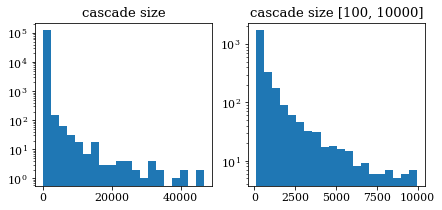

In [16]:
cascade_size = pd.read_csv(data_dir + 'cascade_size.csv')
cascade_size_filtered = cascade_size[(cascade_size.cascade_size >= lower_threshold) & (cascade_size.cascade_size <= upper_threshold)].reset_index(drop=True)

f = plt.figure(figsize=(7,3))

plt.subplot(121)
plt.hist(cascade_size['cascade_size'], bins=20, log=True, range = [cascade_size['cascade_size'].min(), cascade_size['cascade_size'].max()])
plt.title('cascade size')

plt.subplot(122)
plt.hist(cascade_size_filtered['cascade_size'], bins=20, log=True, range = [cascade_size_filtered['cascade_size'].min(), cascade_size_filtered['cascade_size'].max()])
plt.title('cascade size [100, 10000]')

plt.subplots_adjust(wspace=0.2)

plt.show()

f.savefig("../plots/cascade_size.pdf")

In [26]:
cascades = tweets.groupby('cascade_id').mean()

(22155, 15)

In [11]:
pd.set_option('display.precision', 2)
cascades.groupby('veracity').agg({k:['mean', np.std] for k in ['depth', 'size', 'breadth']}).reset_index()       

NameError: name 'cascades' is not defined

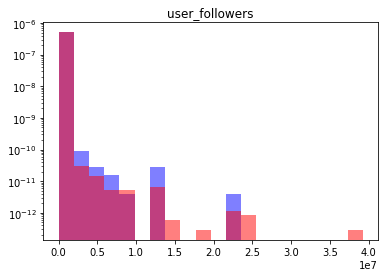

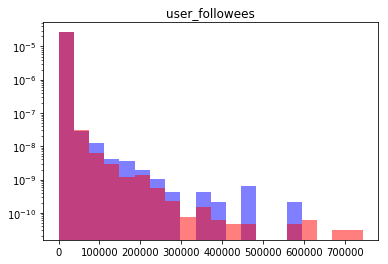

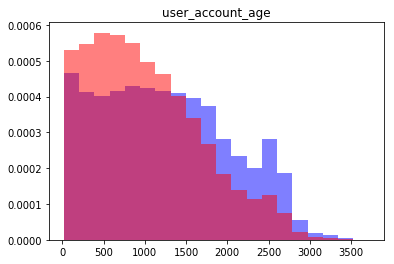

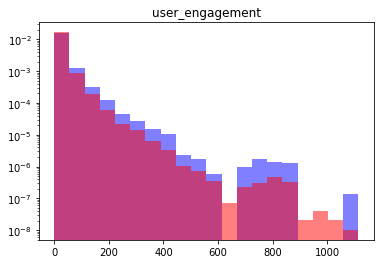

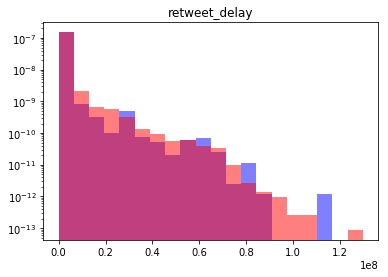

In [24]:
for (c, lg) in zip(to_display, [True, True, False, True, True]):
    plt.hist(tweets[tweets.veracity][c], color='blue', alpha=0.5, density=True,
             bins=20, log=lg, range = [tweets[c].min(), tweets[c].max()])
    plt.hist(tweets[~tweets.veracity][c], color='red', alpha=0.5, density=True,
             bins=20, log=lg, range = [tweets[c].min(), tweets[c].max()])
    plt.title(c)
    plt.show()

In [19]:
cascades[['cascade_size', 'cascade_followers']].describe().style.format('{:.4f}')

,cascade_size,cascade_followers
count,2155.0000,2155.0000
mean,876.4538,2150098.1155
std,1405.0587,3275835.1317
min,100.0000,4269.0000
25%,168.0000,463866.5000
50%,324.0000,1025287.0000
75%,829.0000,2546196.0000
max,9990.0000,43428570.0000


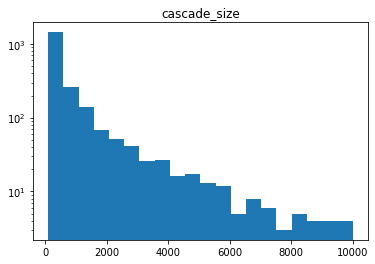

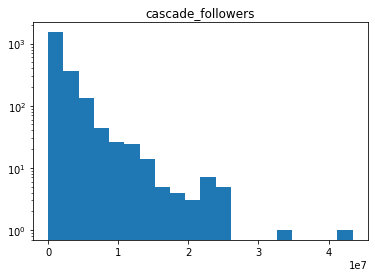

In [22]:
for c in ['cascade_size', 'cascade_followers']:
    plt.hist(cascades[c], bins=20, log=True, range = [cascades[c].min(), cascades[c].max()])
    plt.title(c)
    #plt.savefig('plots/'+c+'.png')
    plt.show()

In [33]:
df_emo = pd.merge(df_emo, cascades[['cascade_id', 'veracity']], how = 'inner', on = 'cascade_id')

In [39]:
emos = ['sadness', 'anticipation', 'disgust', 'surprise', 'anger',
       'joy', 'fear', 'trust']

In [66]:
pd.set_option('display.precision', 3)

df_emo.groupby('veracity').agg({k:'mean' for k in emos}).reset_index().melt('veracity').pivot('variable', 'veracity')

value       
veracity      False  True 
variable                  
anger         0.133  0.131
anticipation  0.142  0.151
disgust       0.225  0.219
fear          0.098  0.100
joy           0.083  0.091
sadness       0.065  0.073
surprise      0.147  0.132
trust         0.107  0.102

In [68]:
df_emo.groupby('veracity').agg({k:np.std for k in emos}).reset_index().melt('veracity').pivot('variable', 'veracity')

value       
veracity      False  True 
variable                  
anger         0.051  0.044
anticipation  0.056  0.053
disgust       0.084  0.070
fear          0.056  0.047
joy           0.050  0.072
sadness       0.034  0.039
surprise      0.070  0.045
trust         0.047  0.044